In [1]:
import numpy as np
import os
import pandas as pd  
import re
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import SGDClassifier, LogisticRegression 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt 
from sklearn.pipeline import Pipeline

In [2]:
current_dir_path = os.getcwd()
data_path = os.path.join(current_dir_path, 'data', 'NLU-Data-Home-Domain-Annotated-All.csv')

In [3]:
df = pd.read_csv(data_path, error_bad_lines=False, sep=';')

In [4]:
# deleting nans, nulls
df = df[pd.notnull(df['answer'])]

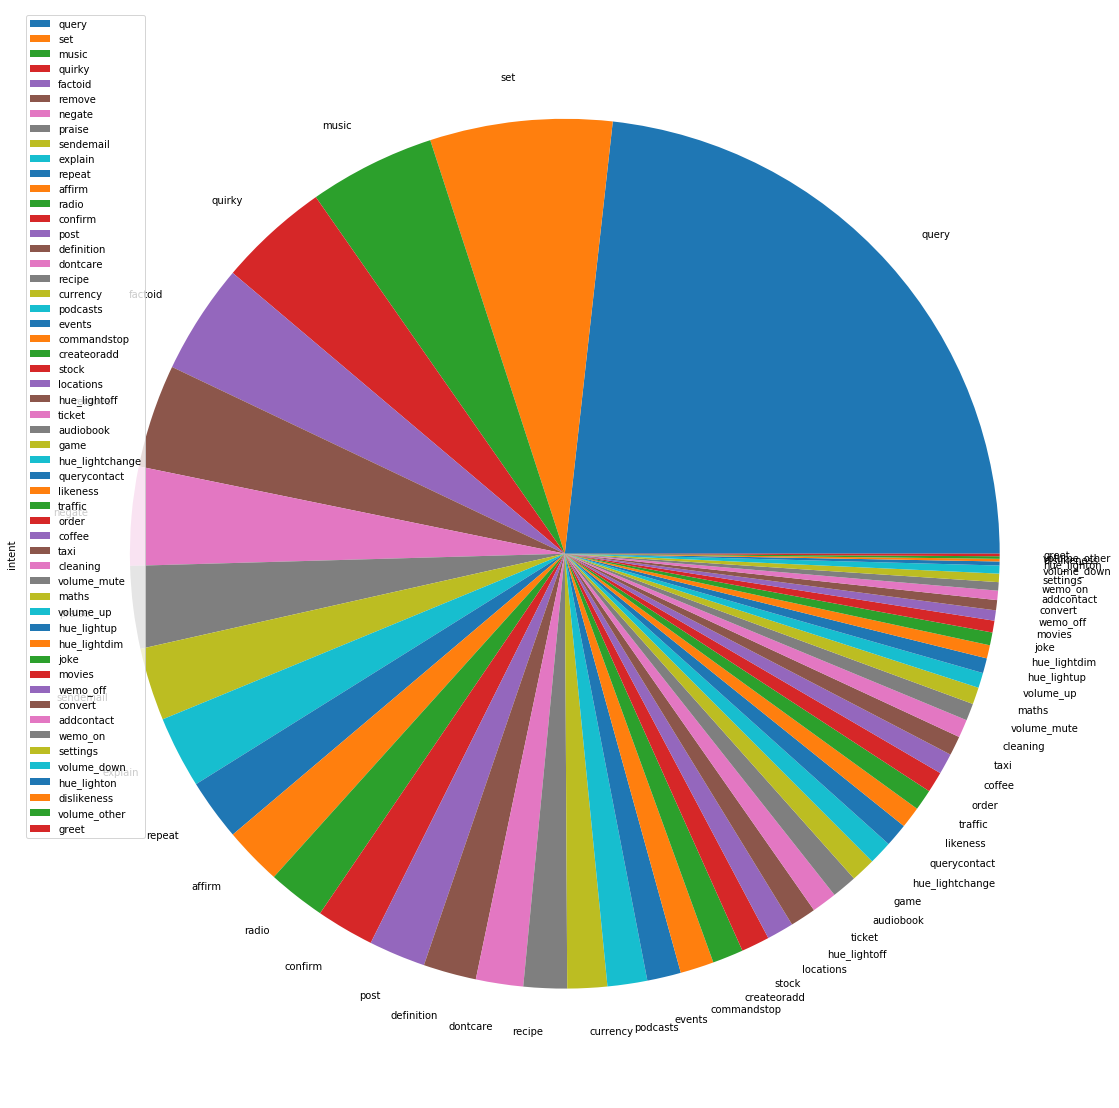

In [5]:
# intents distribution
df['intent'].value_counts().plot(figsize=(30,20), kind='pie', legend=True)

In [6]:
df['intent'].value_counts()

query              5951
set                1733
music              1202
quirky             1057
factoid            1052
remove              984
negate              939
praise              785
sendemail           693
explain             684
repeat              585
affirm              554
radio               551
confirm             550
post                541
definition          504
dontcare            450
recipe              413
currency            378
podcasts            378
events              322
commandstop         320
createoradd         294
stock               270
locations           256
hue_lightoff        246
ticket              239
audiobook           239
game                234
hue_lightchange     224
querycontact        221
likeness            204
traffic             200
order               199
coffee              198
taxi                184
cleaning            172
volume_mute         163
maths               161
volume_up           144
hue_lightup         142
hue_lightdim    

In [7]:
def preprocessing_text(sentence):
    regex = re.compile('[^a-zA-Z0-9 ]')
    sentence = regex.sub(' ', sentence)
    sentence = regex.sub(' +', ' ', sentence)
    sentence = sometext.strip()
    return sentence  

def my_preprocessor(sentence):
    regex = re.compile('[^a-zA-Z0-9 ]')
    return regex.sub(' +', ' ', regex.sub(' ', sentence)).strip()


In [8]:
# data preprocessing
X = df['answer'].str.replace('[^a-zA-Z0-9 ]', '', regex=True)
y = df['intent']

In [9]:
# data train/test split
test_size = 0.2
random_seed = 42
targets_names = df['intent'].unique()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

In [10]:
targets_names

array(['set', 'volume_mute', 'hue_lightchange', 'hue_lightoff',
       'hue_lighton', 'hue_lightdim', 'cleaning', 'query', 'music',
       'quirky', 'greet', 'convert', 'remove', 'likeness', 'hue_lightup',
       'order', 'settings', 'volume_down', 'joke', 'dislikeness',
       'volume_other', 'coffee', 'volume_up', 'wemo_on', 'wemo_off',
       'stock', 'radio', 'post', 'locations', 'recipe', 'sendemail',
       'factoid', 'events', 'audiobook', 'podcasts', 'ticket', 'movies',
       'game', 'traffic', 'definition', 'querycontact', 'createoradd',
       'addcontact', 'taxi', 'maths', 'currency', 'negate', 'dontcare',
       'repeat', 'affirm', 'commandstop', 'confirm', 'explain', 'praise'],
      dtype=object)

In [11]:
models = []
parameters = []

multinomial_nb_clf = MultinomialNB()
multinomial_nb_clf_parameters = {
     'vect__ngram_range': [(1, 1), (1, 2)],
     'tfidf__use_idf': (True, False),
     'clf__alpha': (1e-2, 1e-3) 
}
parameters.append(multinomial_nb_clf_parameters)
models.append(multinomial_nb_clf)

svc_clf = SVC()
svc_clf_parameters = {
     'vect__ngram_range': [(1, 2)],
     'tfidf__use_idf': (True,),
     'clf__kernel': ('rbf',),
     'clf__C': (1.0,)
}
parameters.append(svc_clf_parameters)
models.append(svc_clf)


rf_clf = RandomForestClassifier()
rf_clf_parameters = {
     'vect__ngram_range': [(1, 2)],
     'tfidf__use_idf': (True,),
     'clf__criterion': ('gini',),
     'clf__n_estimators': (100,)
}
parameters.append(rf_clf_parameters)
models.append(rf_clf)

lr_clf = LogisticRegression()
lr_clf_parameters = {
     'vect__ngram_range': [(1, 2)],
     'tfidf__use_idf': (True,),
     'clf__C': (1., 10.,),
     'clf__penalty': ('l2',)
}
parameters.append(lr_clf_parameters)
models.append(lr_clf)

sgd_clf = SGDClassifier()
sgd_clf_parameters = {
     'vect__ngram_range': [(1, 2)],
     'tfidf__use_idf': (True,),
     'clf__alpha': (1e-2,),
     'clf__penalty': ('l2',)
}
parameters.append(sgd_clf_parameters)
models.append(sgd_clf)

In [12]:
def create_pipeline(model_type):
    pipe = Pipeline([
                     ('vect', CountVectorizer(lowercase=True)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', model_type)
    ])
    return pipe


In [13]:
pipe_clfs = list(map(create_pipeline, models))

In [14]:
train_results = []
test_results_reports = []
test_results_cms = []
for pipe_clf, param_grid in zip(pipe_clfs, parameters):
    print(pipe_clf)
    gs_clf = GridSearchCV(pipe_clf,
                          param_grid,
                          cv=5,
                          scoring=['f1_macro', 'f1_micro', 'accuracy'],
                          verbose=10,
                          n_jobs=-1,
                          refit='f1_macro'
                          )
    gs_clf = gs_clf.fit(X_train, y_train)
    df = pd.DataFrame(gs_clf.cv_results_)
    train_results.append(df)
    print(df)
    
    predicted = gs_clf.predict(X_test)
    test_results_reports.append(metrics.classification_report(y_test, predicted, target_names=targets_names))
    print(test_results_reports[-1])
    test_results_cms.append(metrics.confusion_matrix(y_test, predicted))
    print(test_results_cms[-1])
    
    

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.6s remaining:   17.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.6s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.7s finished


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        6.22192      1.663682         0.553151        0.161361   

  param_clf__alpha param_clf__penalty param_tfidf__use_idf  \
0             0.01                 l2                 True   

  param_vect__ngram_range                                             params  \
0                  (1, 2)  {'clf__alpha': 0.01, 'clf__penalty': 'l2', 'tf...   

   split0_test_f1_macro  ...  std_test_f1_micro  rank_test_f1_micro  \
0              0.676358  ...            0.00492                   1   

   split0_test_accuracy  split1_test_accuracy  split2_test_accuracy  \
0              0.770808              0.776666              0.777154   

   split3_test_accuracy  split4_test_accuracy  mean_test_accuracy  \
0               0.77813              0.765194             0.77359   

   std_test_accuracy  rank_test_accuracy  
0            0.00492                   1  

[1 rows x 33 columns]
                 precision    recall  f1-scor

/home/michal/miniconda3/envs/nn2019/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
